In [1]:
using Distributions
using Random
using scBayesDeconv
using Plots
using DataFrames
using CSV

# Distributions 1D

## Noise distributions

In [2]:
dNoise = Dict()

dNoise["Normal"] = Normal(0,1)
dNoise["SkewNormal"] = SkewNormal(-1.32,1.65,7)
# dNoise["BimodalAsym"] = MixtureModel([
#                         Normal(-0.82-0.16,0.41),
#                         Normal(0.82-0.16,0.71),
#                         ],[.4,.6])
# dNoise["BimodalSym"] = MixtureModel([
#                         Normal(-0.9,0.5),
#                         Normal(0.9,0.5),
#                         ],[.5,.5])
# dNoise["TrimodalAsym"] = MixtureModel([
#                         Normal(-1.7+.08,0.65),
#                         Normal(0+.08,0.35),
#                         Normal(1.3+.08,0.35),
#                         ],[.2,.6,.2])
# dNoise["TrimodalSym"] = MixtureModel([
#                         Normal(-1.3,0.65),
#                         Normal(0,0.15),
#                         Normal(1.3,0.65),
#                         ],[.25,.5,.25])
dNoise["Student"] = TDist(3) 
# dNoise["Binomial"] = MixtureModel(
#     Normal[
#         Normal(-2,1),
#         Normal(6,1)
#     ],
#     [.5,.5]
#     )
# dNoise["Laplace"] = Laplace(0,.72) 
# dNoise["LaplaceSharp"] = MixtureModel([
#                         Laplace(0.,0.2),
#                         Laplace(0.,0.1),
#                         ],[.5,.5]);

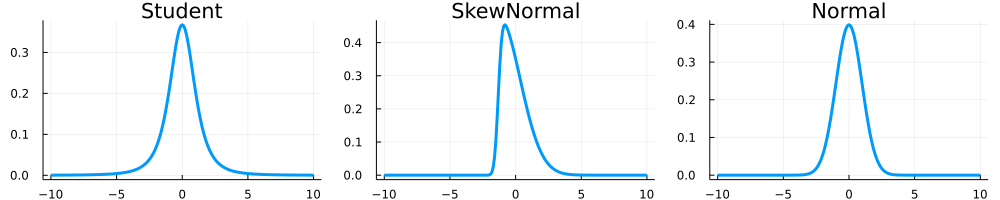

In [3]:
x = -10:.1:10

l = []
for (i,j) in pairs(dNoise)
    push!(l,plot(x,pdf.(j,x),title=i,linewidth=3,label=""))
end

plot(l...,layout=(1,3),size=[1000,200])

## Target distributions

In [4]:
dTarget = Dict()

dTarget["BimodalAsym"] = MixtureModel([
                        Normal(-0.82-0.16,0.41),
                        Normal(0.82-0.16,0.71),
                        ],[.6,.4])
dTarget["BimodalSym"] = MixtureModel([
                        Normal(-0.9,0.5),
                        Normal(0.9,0.5),
                        ],[.5,.5])
dTarget["SkewNormal"] = SkewNormal(-1.32,1.65,7)


SkewNormal{Float64}(ξ=-1.32, ω=1.65, α=7.0)

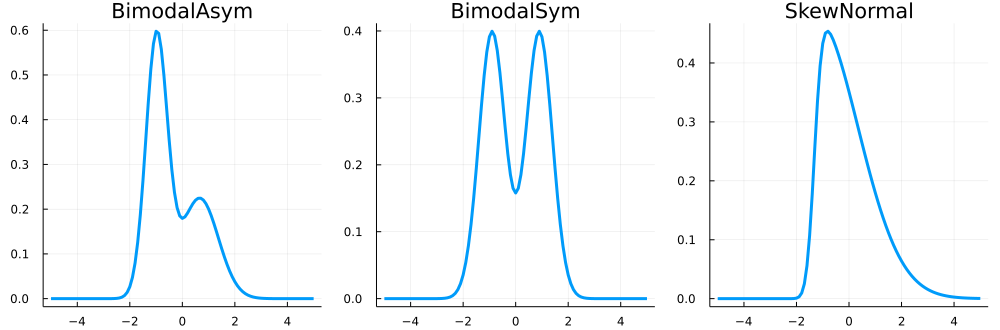

In [5]:
x = -5:.1:5

l = []
for (i,j) in pairs(dTarget)
    push!(l,plot(x,pdf.(j,x),title=i,linewidth=3,label=""))
end

plot(l...,layout=(1,3),size=[1000,330])

## Convolved distributions

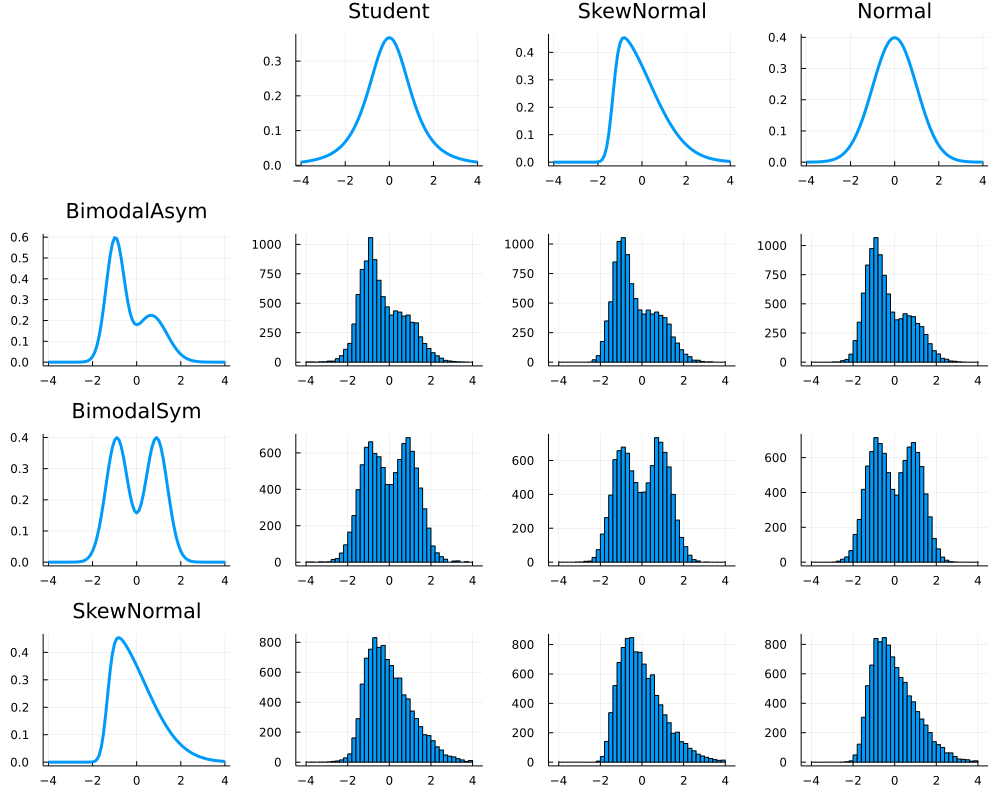

In [6]:
x = -4:.1:4
bins=-4:.2:4
plots = []
snr=4

push!(plots,plot(ticks=nothing,axis=false))
for (i,dn) in pairs(dNoise)

    push!(plots,plot(x,pdf.(dn,x),title=i,linewidth=3,label=""))

end

for (j,dt) in pairs(dTarget)

    push!(plots,plot(x,pdf.(dt,x),title=j,linewidth=3,label=""))

    for (i,dn) in pairs(dNoise)

        data = rand(dn,10000)/snr+rand(dt,10000)
        push!(plots,histogram(data,bins=bins,label=""))

    end

end


plot(plots...,layout=(4,4),size=(1000,800))

## Sample deconvolution

In [7]:
N = 1000
snr = 2
dn = dNoise["Normal"]
dt = dTarget["BimodalAsym"]

noise = rand(dn,N)/snr
target = rand(dt,N)
convolution = rand(dn,N)/snr+rand(dt,N);

In [8]:
y,x = newmannDeconvolution(noise,convolution);

In [9]:
dnfitted = infiniteGaussianMixture(reshape(noise,length(noise),1))
dtfitted = infiniteGaussianMixtureDeconvolution(reshape(convolution,length(convolution),1),dnfitted);

In [10]:
N = 1000

noise = rand(dn,N)/snr
target = rand(dt,N)
convolution = rand(dn,N)/snr+rand(dt,N)

p1 = histogram(convolution,bins=-4:.1:5,title="Convolution",label="",normalize=true,color="green",ylabel="p(x)",xlabel="x")
histogram!(noise,bins=-2:0.1:2,inset=(1,bbox(.7,.15,.25,.4)),subplot=2,bg_inside=nothing,label="",normalize=true,title="Autofluorescence",titlefontsize=8,color="magenta",ylabel="p(x)",xlabel="x")

p2 = histogram(target,bins=-4:.1:4,title="Bayesian deconvolution",normalize=true,color="lightblue",ylabel="p(x)",xlabel="x",label="Sample deconvolution")
x = -4:.1:4
plot!(p2,pdf(dtfitted.samples[2],reshape(x,1,length(x))),label="Bayesian deconvolution")
for i in 2:100
    plot!(p2,pdf(dtfitted.samples[i],reshape(x,1,length(x))),label="")
end
xlims!(-4,4)

p3 = histogram(target,bins=-4:.1:4,title="FFT deconvolution",normalize=true,color="lightblue",ylabel="p(x)",xlabel="x",label="Sample deconvolution")
plot!(p3,x,y,linewidth=2,label="FFT deconvolution")
xlims!(-4,4)

plot(p1,p2,p3,layout=(1,3),size=[1100,220])

## Deconvolutions

In [11]:
x = -10:.1:10

resultsNoise = DataFrame()
resultsDeconvolution = DataFrame()
for snr in [10,5,1]
    for size in [100,1000]
        for (i,dn) in pairs(dNoise)

            n = reshape(nRatio*rand(dn,size),size,1)
            fitNoise = infiniteGaussianMixture(n,κ0=0.001,k=1)

            if nRatio == 1
                fn(x) = pdf(dn,x[1])
                miae = []
                for k in 2:1:100
                    f2(x) = pdf(fitNoise.samples[k],x)
                    push!(miae, scBayesDeconv.metrics.MIO(fn,f2,[-100. 100.],.1))
                end

                append!(resultsNoise,
                    ["Noise"=>i,"Ratio"=>nRatio,"Size"=>size,"MIO"=>mean(miae)]
                )
                CSV.write("Noise.csv", string.(resultsNoise))
            end

            for (j,dt) in pairs(dTarget)

                t = reshape(rand(dt,size),size,1)
                c = reshape(nRatio*rand(dn,size).+rand(dt,size),size,1)
                
                fitConvolution = infiniteGaussianMixtureDeconvolution(c,fitNoise,k=1)

                ft(x) = pdf(dt,x[1])
                miae = scBayesDeconv.metrics.MIO(fitConvolution,ft)

                append!(resultsDeconvolution,
                    ["Noise"=>i,"Target"=>j,"Ratio"=>nRatio,"Size"=>size,"MIO"=>mean(miae)]
                )
                CSV.write("Deconvolution.csv", string.(resultsDeconvolution))

            end

        end
    end
end